# SeasFire Datacube access and basic analytics

This notebook shows basic utilities to load and process the SeasFire DataCube with xarray. It contains basic instructions showing how to access, process and visualize the data.

## Initial Imports

We start by importing the libraries we need. Make sure to have them installed in your system, using conda or pip packaging systems.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import xarray as xr
import zarr
import s3fs
import time

In [2]:
from dotenv import load_dotenv
load_dotenv("osc-cloudferro.env") 
#load_dotenv("prr.env") 

True

## Download and Access DataCube

We download the datacube from SeasFire DataCube in the form of a zarr file from Zenodo and Google drive.  
- Download complete dataset from [Zenodo](https://zenodo.org/record/13834057) 


In [3]:
# Instructions to download from Zenodo (100 GB Zarr file)

# Download zipped cube
#!wget https://https://zenodo.org/records/13834057/seasfire_v0.4.zip
    
# Extract from zip file
#!unzip seasfire_v0.4.zip

#!ls

import os

print(os.getenv("AWS_ACCESS_KEY_ID"))
print(os.getenv("AWS_SECRET_ACCESS_KEY")[0] + "...")
print(os.getenv("AWS_REGION"))
print(os.getenv("AWS_ENDPOINT_URL"))
print(os.getenv("ROOT"))


7434f8ed4ec9410ca8a037f1de88abe8
e...
default
https://s3.waw4-1.cloudferro.com
EarthCODE/OSCAssets/seasfire/seasfire_v0.4.zarr


In [4]:
#dataset=xr.open_zarr(Path.home() / 'seasfire_v0.4.zarr')

fs = s3fs.S3FileSystem(
    anon=False,
    key=os.getenv("AWS_ACCESS_KEY_ID"),
    secret=os.getenv("AWS_SECRET_ACCESS_KEY"),
    client_kwargs = {k: v for k in ("region_name", "endpoint_url") if (v := os.getenv(f"AWS_{k.upper()}"))},
    config_kwargs={"max_pool_connections": 64},
    #default_fill_cache=False,
)

store = s3fs.S3Map(
    root=os.getenv("ROOT"),
    s3=fs,
    check=False
)

import dask
from multiprocessing.pool import ThreadPool
dask.config.set(scheduler="threads", pool=ThreadPool(8))

In [5]:
%%time
dataset = xr.open_zarr(store, consolidated=True, chunks="auto")

CPU times: user 968 ms, sys: 236 ms, total: 1.2 s
Wall time: 2.09 s


## Datacube Dimensions 

In [6]:
dataset

<xarray.Dataset> Size: 164GB
Dimensions:                         (latitude: 720, longitude: 1440, time: 966)
Coordinates:
  * latitude                        (latitude) float64 6kB 89.88 ... -89.88
  * longitude                       (longitude) float64 12kB -179.9 ... 179.9
  * time                            (time) datetime64[ns] 8kB 2001-01-01 ... ...
Data variables: (12/59)
    area                            (latitude, longitude) float32 4MB dask.array<chunksize=(180, 360), meta=np.ndarray>
    biomes                          (latitude, longitude) float32 4MB dask.array<chunksize=(180, 360), meta=np.ndarray>
    cams_co2fire                    (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    cams_frpfire                    (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    drought_code_max                (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    drought_code_mean               (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ...                              ...
    t2m_max                         (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2m_mean                        (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2m_min                         (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    tp                              (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    vpd                             (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ws10                            (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
Attributes:
    crs:          EPSG:4326
    description:  The SeasFire Cube is a scientific datacube for seasonal fir...
    title:        SeasFire Cube: A Global Dataset for Seasonal Fire Modeling ...

We easily observe that the dataset has three(3) dimensions, which are the 
- longitude(x)
- latitude(y) 
- time.

Spatio-Temporal Coverage:
- 2001 to 2021 ( 21 years) 
- Global 
- 26 input variables
- 4 target variables 
- static variables do not match the weekly resolution of the rest of the dataset 
- there are missing years for some variables, refer to the documentation for more information 
-  We have a  720 × 1440 rasters for each 8-day period of time. This is why time dimension is 966.
- Each input variable contains a numpy array with dimensions 966x720x1440 **(time * x * y )** 

# Performance Playground

In [7]:
%%time
dss = dataset[["t2m_mean", "ws10", "rel_hum", "gfed_ba", "sst"]].isel(time=slice(100, 300))
dss

CPU times: user 4.91 ms, sys: 0 ns, total: 4.91 ms
Wall time: 4.67 ms


<xarray.Dataset> Size: 4GB
Dimensions:    (time: 200, latitude: 720, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * longitude  (longitude) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time       (time) datetime64[ns] 2kB 2003-03-06 2003-03-14 ... 2007-07-04
Data variables:
    t2m_mean   (time, latitude, longitude) float32 829MB dask.array<chunksize=(200, 180, 360), meta=np.ndarray>
    ws10       (time, latitude, longitude) float32 829MB dask.array<chunksize=(200, 180, 360), meta=np.ndarray>
    rel_hum    (time, latitude, longitude) float32 829MB dask.array<chunksize=(200, 180, 360), meta=np.ndarray>
    gfed_ba    (time, latitude, longitude) float32 829MB dask.array<chunksize=(200, 180, 360), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 829MB dask.array<chunksize=(200, 180, 360), meta=np.ndarray>
Attributes:
    crs:          EPSG:4326
    description:  The SeasFire Cube is a scientific datacube for seasonal fir...
    title:        SeasFire Cube: A Global Dataset for Seasonal Fire Modeling ...

In [8]:
%%time
dss.load()

CPU times: user 40.9 s, sys: 15.2 s, total: 56.1 s
Wall time: 39.6 s


<xarray.Dataset> Size: 4GB
Dimensions:    (time: 200, latitude: 720, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * longitude  (longitude) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time       (time) datetime64[ns] 2kB 2003-03-06 2003-03-14 ... 2007-07-04
Data variables:
    t2m_mean   (time, latitude, longitude) float32 829MB 240.6 240.6 ... 218.6
    ws10       (time, latitude, longitude) float32 829MB 5.838 5.834 ... 5.51
    rel_hum    (time, latitude, longitude) float32 829MB 101.0 101.0 ... 83.45
    gfed_ba    (time, latitude, longitude) float32 829MB nan nan nan ... 0.0 0.0
    sst        (time, latitude, longitude) float32 829MB 271.5 271.5 ... nan nan
Attributes:
    crs:          EPSG:4326
    description:  The SeasFire Cube is a scientific datacube for seasonal fir...
    title:        SeasFire Cube: A Global Dataset for Seasonal Fire Modeling ...

## Plotting and Analytics

In this section, we'll see some basic functionality showing how to select and visualize the variables in the datacube.
1. Plotting the 2 metre temperature in the whole earth at specific 8-days period of time
2. Plotting the 2 metre temperature for a specific pixel (815x205 --> Greece) in the dataset for all years between 2001 and 2021. We can plot both the time-series of the temperature and a histogram of the values
3. Plotting the 2 metre temperature for a specific pixel (815x205 --> Greece) in the dataset for all periods in the year 2021.
4.  PLotting the wind speed for the whole earth for a series of 8-days time periods.
5. Plotting the relative humidity for the whole earth for the same time periods as above.
6. Plotting the BurntArea for the whole earth for the same time periods as above. 

In [9]:
def select_spatio_temporal_data(dataset, initial_timestep, timesteps, latitude, longitude):
    '''
    Desc
    ----
    Method to select a subset of the cube.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
        * if we want all the latitudes, we set the value = -1
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
        * if we want all the longitudes, we set the value = -1    
    '''
    
    if(latitude == -1 and longitude == -1):
        return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps))
    
    return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps), latitude=latitude, longitude=longitude)

In [10]:
def select_variable_data(dataset, variable_name):
    '''
    Desc
    ----
    Method to select a particular variable (such as relaive humidity, windspeed, sst etc)
    from the DataCube.
    
    Args
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    '''
    
    return dataset[variable_name]

In [11]:
def earth_graph(dataset, variable_name, initial_timestep, timesteps, latitude=-1, longitude=-1, col_wrap=1):
    '''
    Desc
    ----
    Method to plot whole earth for specific variable for specific time interval.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    col_wrap: int
        *how many graphs will be plotted i the same row
    latitude: int
        * value = -1, that is whole earth
    longitude: int
        * value = -1, that is whole earth
    '''
    
    if (timesteps==1):

        select_spatio_temporal_data(select_variable_data(dataset, variable_name), 
                                    initial_timestep, 
                                    timesteps, 
                                    latitude, 
                                    longitude).plot()
    else:
        
        select_spatio_temporal_data(select_variable_data(dataset, variable_name), 
                                    initial_timestep, 
                                    timesteps, 
                                    latitude, 
                                    longitude).plot(x="longitude", 
                                                    y="latitude", 
                                                    col="time", 
                                                    col_wrap=col_wrap)

CPU times: user 8.88 s, sys: 2.74 s, total: 11.6 s
Wall time: 8.66 s


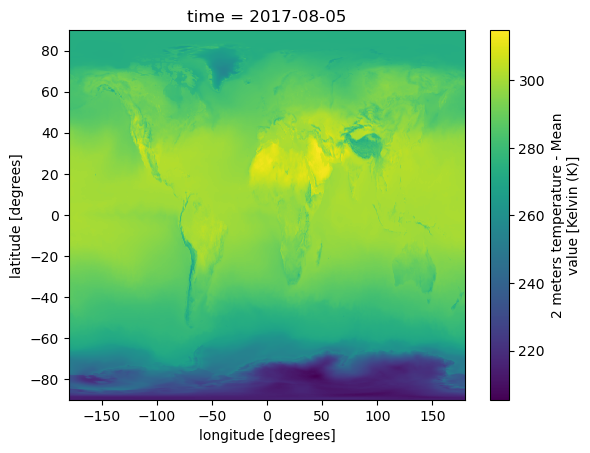

In [12]:
%%time
earth_graph(dataset, 't2m_mean', 763, 1, -1, -1)

In [13]:
def trend_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude):
    '''
    Desc
    ----
    Method to plot a specific point in earth for specific time interval and variable.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
    '''
    
    plt.figure(figsize=(10, 4))
    select_spatio_temporal_data(select_variable_data(dataset, variable_name), 
                                initial_timestep, 
                                timesteps, 
                                latitude, 
                                longitude).plot(linewidth=2, color='#5f0f40')
    plt.show()

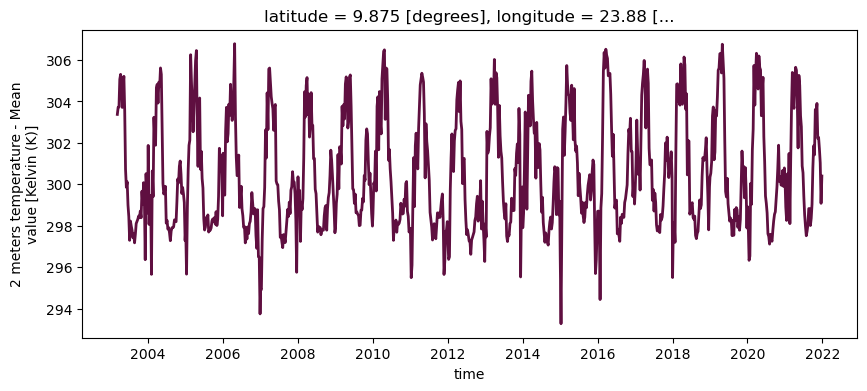

CPU times: user 1.19 s, sys: 209 ms, total: 1.39 s
Wall time: 2.66 s


In [14]:
%%time
trend_graph(dataset, 't2m_mean', 100, 900, 320, 815)

In [15]:
def hist_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude):
    '''
    Desc
    ----
    Method to plot a histogram for a specific variable in a specific point in earth for a given time interval.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
    '''
    
    plt.figure(figsize=(5, 3))
    select_spatio_temporal_data(select_variable_data(dataset, variable_name), 
                                initial_timestep, 
                                timesteps, 
                                latitude, 
                                longitude).plot.hist(color='#0f4c5c')
    plt.show()  

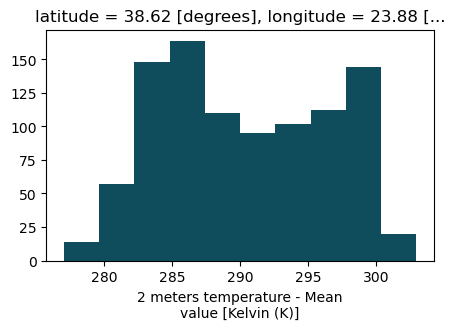

CPU times: user 1.01 s, sys: 233 ms, total: 1.24 s
Wall time: 2.49 s


In [16]:
%%time
hist_graph(dataset, 't2m_mean', 0, 966, 205, 815)

In [17]:
def plot_graphs(dataset, variable_name, initial_timestep, timesteps, latitude, longitude, col_wrap=1):
    '''
    Desc
    ----
    Method to plot graphs for specific variables from the dataset.
    
    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
        * if we want all the latitudes, we set the value = -1
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
        * if we want all the longitudes, we set the value = -1 
    col_wrap: int
        * how many graphs will be plotted i the same row
    '''
    
    assert timesteps >= 1, 'timesteps must be larger or equal to one'
    
    if(latitude == -1 and longitude == -1): #whole earth for a specific time interval and variable
        
        earth_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude, col_wrap)
        
    else:  # specific point in earth for specific time interval and variable

        #trend plot
        trend_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude)
        plt.show()
        
        #histogram plot
        hist_graph(dataset, variable_name, initial_timestep, timesteps, latitude, longitude)
        plt.show()  

### Plotting the 2 metre temperature in the whole earth at specific 8-days period of time

CPU times: user 8.99 s, sys: 2.6 s, total: 11.6 s
Wall time: 8.76 s


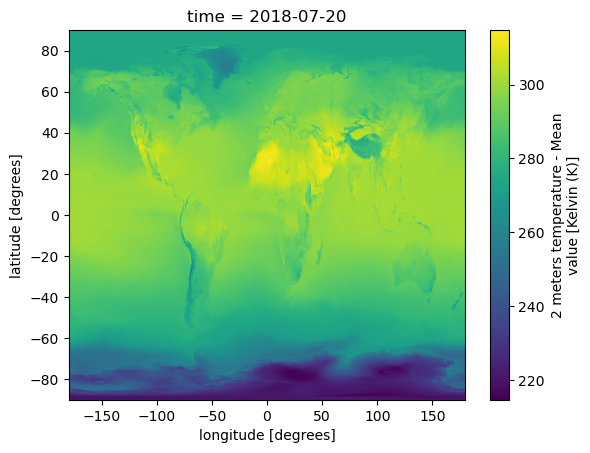

In [18]:
%%time
plot_graphs(dataset, 't2m_mean', 807, 1, -1, -1)

### Plotting the 2 metre temperature for a specific pixel (815x205 --> Greece) in the dataset for all years between 2001 and 2021. We can plot both the time-series of the temperature and a histogram of the values.

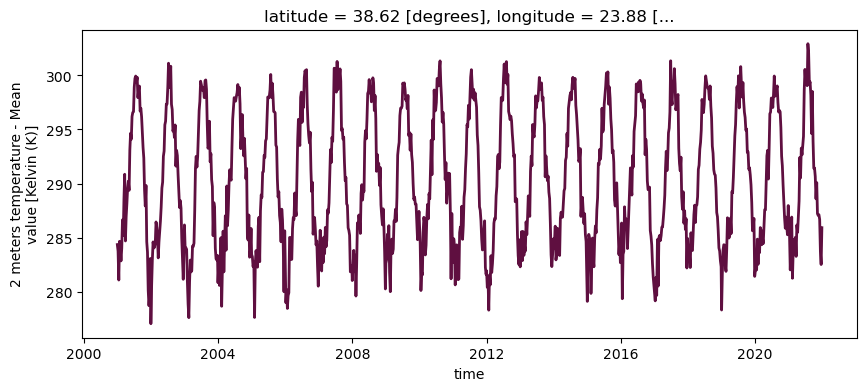

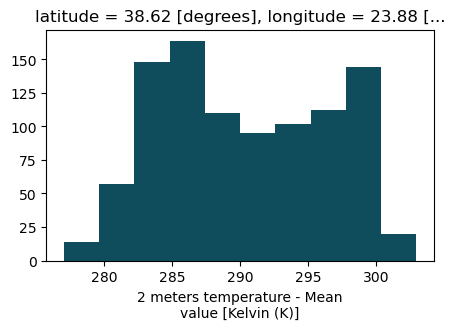

CPU times: user 2.06 s, sys: 519 ms, total: 2.58 s
Wall time: 4.71 s


In [19]:
%%time
plot_graphs(dataset, 't2m_mean', 0, 966, 205, 815)

### Plotting the 2 metre temperature for a specific pixel (815x205 --> Greece) in the dataset for all periods in the year 2021.

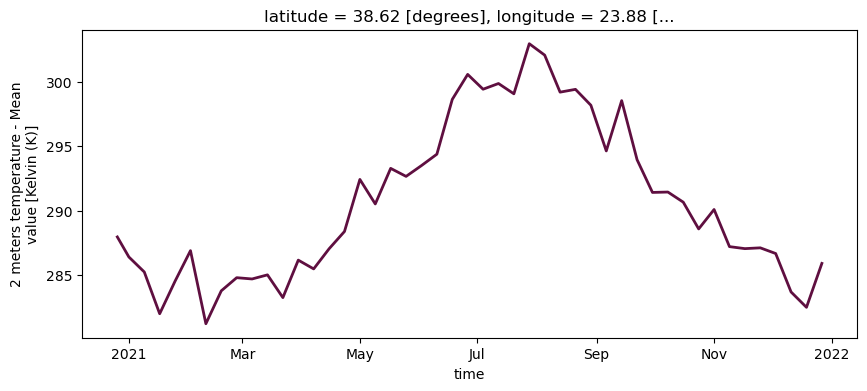

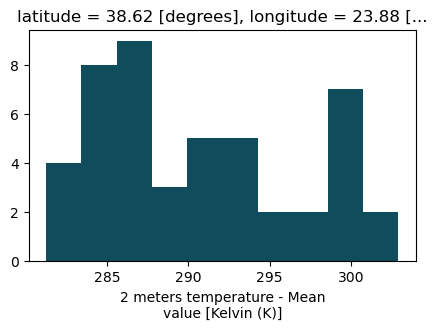

CPU times: user 1.98 s, sys: 484 ms, total: 2.47 s
Wall time: 4.44 s


In [20]:
%%time
plot_graphs(dataset, 't2m_mean', 919, 47, 205, 815)

### Potting the wind speed for the whole earth for a series of 8-days time periods.

In [ ]:
%%time
plot_graphs(dataset, 'ws10', 70, 9, -1, -1, col_wrap=3)

### Plotting the relative humidity for the whole earth for the same time periods as above.

In [ ]:
%%time
plot_graphs(dataset, 'rel_hum', 70, 9, -1, -1, col_wrap=3)

### Plotting the BurntArea for the whole earth for the same time periods as above. 

In [ ]:
%%time
plot_graphs(dataset, 'gfed_ba', 70, 9, -1, -1, col_wrap=3)